In [2]:
import numpy as np
from numpy.random import normal as Gauss
import matplotlib.pyplot as plt
import h5py
%matplotlib inline
from numpy.random import randn

In [3]:
class DatasetLoader:    
    def __init__(self, path):
        self.path = path        

    def load(self):        
        with h5py.File(self.path,'r') as F:
            names = list(F.keys())
            X_train = np.array(F[names[3]].value)
            y_train = np.array(F[names[2]].value)
            X_test = np.array(F[names[1]].value)
            y_test = np.array(F[names[0]].value)
            X_val = np.array(F[names[5]].value)
            y_val = np.array(F[names[4]].value)
            words = np.array(F[names[-1]].value)

            return {'TrainX': X_train, 'TrainY' : y_train,
                    'TestX' : X_test,  'TestY'  : y_test,
                    'ValX'  : X_val,   'ValY'  : y_val,
                    'Corpus': words}
    
path = 'assign2_data2.h5'
data = DatasetLoader(path).load()

In [4]:
class OneHotEncode:
    def __init__(self):        
        self.vocab_size = 250
           
    def vectorize2D(self,Y):
        size = Y.shape[0]
        val = np.zeros((size,self.vocab_size))        

        for i in range(size):
            val[i,int(Y[i])-1]=1             
        return val
    
    def vectorize3D(self,X):
        size = X.shape[0]
        val1 = np.zeros((size,3,self.vocab_size))
        
        for i in range(size):
            for j in range(3):
                out = np.zeros(self.vocab_size)
                out[X[i,j]-1] = 1
                val1[i,j,:] = out
        return val1
    
    def transform(self,data,vector):   
        if vector == '3D':
            return  self.vectorize3D(data)
        else:
            return  self.vectorize2D(data)

In [5]:
OneHotEncoder = OneHotEncode()
data['EncodedTrainY'] = OneHotEncoder.transform(data['TrainY'], vector = '2D')
data['EncodedTestY'] = OneHotEncoder.transform(data['TestY'],vector = '2D')
data['EncodedValY'] = OneHotEncoder.transform(data['ValY'], vector = '2D')

data['EncodedTrainX'] = OneHotEncoder.transform(data['TrainX'], vector = '3D')
data['EncodedTestX'] = OneHotEncoder.transform(data['TestX'],vector = '3D')
data['EncodedValX'] = OneHotEncoder.transform(data['ValX'], vector = '3D')

In [6]:
print(f"One hot encode training data dimension     :  {data['EncodedTrainX'].shape}")
print(f"One hot encode training label dimension    :  {data['EncodedTrainY'].shape}")
print(f"One hot encode validation data  dimension  :  {data['EncodedValX'].shape}")
print(f"One hot encode validation label  dimension :  {data['EncodedValY'].shape}")
print(f"One hot encode testing data  dimension     :  {data['EncodedTestX'].shape}")
print(f"One hot encode testing label  dimension    :  {data['EncodedTestY'].shape}")

One hot encode training data dimension     :  (372500, 3, 250)
One hot encode training label dimension    :  (372500, 250)
One hot encode validation data  dimension  :  (46500, 3, 250)
One hot encode validation label  dimension :  (46500, 250)
One hot encode testing data  dimension     :  (46500, 3, 250)
One hot encode testing label  dimension    :  (46500, 250)


In [7]:
train_data = np.sum((data['EncodedTrainX'][:,0,:],data['EncodedTrainX'][:,1,:],data['EncodedTrainX'][:,2,:]),axis=0)
train_label = data['EncodedTrainY']
val_data = np.sum((data['EncodedValX'][:,0,:],data['EncodedValX'][:,1,:],data['EncodedValX'][:,2,:]),axis=0)
val_label = data['EncodedValY']
test_data = np.sum((data['EncodedTestX'][:,0,:],data['EncodedTestX'][:,1,:],data['EncodedTestX'][:,2,:]),axis=0)
test_label = data['EncodedTestY']
emded_size = 32
hidden_size = 256

In [516]:
train_data_conc = np.concatenate((data['EncodedTrainX'][:,0,:],data['EncodedTrainX'][:,1,:],data['EncodedTrainX'][:,2,:]),axis=1)
train_label_conc = data['EncodedTrainY']
val_data_conc = np.concatenate((data['EncodedValX'][:,0,:],data['EncodedValX'][:,1,:],data['EncodedValX'][:,2,:]),axis=1)
val_label_conc = data['EncodedValY']
test_data_conc = np.concatenate((data['EncodedTestX'][:,0,:],data['EncodedTestX'][:,1,:],data['EncodedTestX'][:,2,:]),axis=1)
test_label_conc = data['EncodedTestY']

In [9]:
print(f"One hot encode training data dimension     :  {train_data_conc.shape}")
print(f"One hot encode val label dimension         :  {train_data_conc.shape}")

One hot encode training data dimension     :  (372500, 750)
One hot encode val label dimension         :  (46500, 750)


In [518]:
def do_not_compute():
    best_model = None
    best_val = -1
    lr = [0.01,0.05,0.1,0.15,0.3,0.5,0.1,0.17]
    batch_size = [50,100,150,200,250,150,250,100]
    alpha = [0.1,0.3,.5,0.7,0.85,0.9,0.6,0.4]
    acc = []
    for i in range(8):
        model = Word2Vec(embed_size=32,hidden_size=256,lr=lr[i],batch_size=batch_size[i],alpha=alpha[i])
        #model.fit(X_feed,data['TrainY'],30)
        preds = model.predict(X_test); labels = np.argmax(data['TestY'],1)
        val_acc = accuracy(preds,labels)
        acc.append(val_acc)

        if best_val < val_acc :
            best_val = val_acc
            best_model = model  

In [519]:
class Word2Vec:   

    def __init__(self,embed_size,hidden_size):
        np.random.seed(42)
        self.lr = 0.15
        self.batch_size = 250
        self.alpha = 0.85
        
        self.loss_train_list = []
        self.loss_test_list = []
        self.acc_train_list = []
        self.acc_test_list = []

        self.prev_updates = {'WE':0,'W1':0,'W2':0,
                             'B1':0,'B2':0}
        
        self.D = embed_size
        self.P = hidden_size
        
        self.sample_size = data['TrainX'].shape[0]
        self.feature_size = data['TrainX'].shape[1]
        self.vocab_size = data['Corpus'].shape[0]

        self.n_update = round((self.sample_size/self.batch_size))
        
        self.W_emb_size = self.vocab_size,self.D
        self.W1_size = self.D,self.P        
        self.W2_size = self.P,self.vocab_size
        self.B1_size = 1,self.P 
        self.B2_size = 1,self.vocab_size        
        
        self.WE =  Gauss(0,scale = 0.01, size = (self.W_emb_size)) 
        self.W1 = Gauss(0,scale = 0.01, size = (self.W1_size)) 
        self.W2 = Gauss(0,scale = 0.01, size = (self.W2_size)) 
        self.B1 = Gauss(0,scale = 0.01, size = (self.B1_size)) 
        self.B2 = Gauss(0,scale = 0.01, size = (self.B2_size)) 
    
    def sigmoid(self,X):
        return 1/(1 + np.exp(-X))   
  

    def MinMaxScaling(self,X):
        return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

    def softmax_stable(self,X):
        e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)
        

    def log_softmax_stable(self,x):
        e_x = np.exp(x - np.max(x))
        return np.log(e_x / np.sum(x,axis=0))

    def log_softmax(self,x):
        x = x - np.max(x)   
        a = np.logaddexp.reduce(x)
        return np.exp(x - a)
        
    def CrossEntropyLoss(self,pred,label):        
        m = pred.shape[0]

        preds = np.clip(pred, 1e-16, 1 - 1e-16)
        loss = np.sum(-label * np.log(preds) - (1 - label) * np.log(1 - preds))        
        return loss/m 
    

    def linear(self,inp,W):
        return np.dot(inp,W) 

    def forward(self,X):        
        emb_linear = self.linear(X,self.WE)
              
        Z1 = self.linear(emb_linear,self.W1) - self.B1
        
        A1 = self.sigmoid(Z1)      
        Z2 = self.linear(A1,self.W2) - self.B2 
             
        A2 = self.softmax_stable(Z2)
              
        return {"Z1": Z1,"A1": A1,
                "Z2": Z2,"A2": A2,
                "E" : emb_linear}
    
    def sigmoid_gradient(self,X):
        return self.sigmoid(X) * (1-self.sigmoid(X))
    
    def softmax_gradient_dZ(self,A2,Y):
        return A2-Y

    def linear_gradients(self,inp,delta): 
        return { 'dW' : self.linear(inp,delta)/self.batch_size,
                 'dB' : np.sum(delta, axis=0, keepdims=True)/self.batch_size}


    def cross_entropy_gradient(self, preds, label):        
        preds = np.clip(preds, 1e-15, 1 - 1e-15)
        grad_ce = - (label/preds) + (1 - label) / (1 - preds)
        return grad_ce

    def softmax_stable_gradient(self, X):
        soft_out = self.softmax_stable(X)       
        return soft_out * (1 - soft_out) 

    def backward(self,outs, X, Y):       
        
        E  = outs['E']
        Z1 = outs['Z1']
        A1 = outs['A1']
        Z2 = outs['Z2']
        A2 = outs['A2']
        
                      
        dZ2 = self.cross_entropy_gradient(A2,Y) * self.softmax_stable_gradient(Z2) 
        dW2 = self.linear_gradients(A1.T,dZ2)['dW']
        dB2 = self.linear_gradients(A1.T,dZ2)['dB']
        
        dZ1 = self.linear(dZ2,self.W2.T) * self.sigmoid_gradient(Z1)
        dW1 = self.linear_gradients(E.T ,dZ1)['dW']
        dB1 = self.linear_gradients(E.T ,dZ1)['dB']
        
        dEmbed = self.linear(dZ1,self.W1.T)     
        dWE = self.linear_gradients(X.T,dEmbed)['dW']
        
        return {"dW1": dW1, "dW2": dW2,
                "dB1": dB1, "dB2": dB2,
                "dWE": dWE}

    def SGD(self,grads):
        delta_E  = -self.lr * grads['dWE'] +  self.alpha * self.prev_updates['WE']
        delta_W1 = -self.lr * grads['dW1'] +  self.alpha * self.prev_updates['W1']
        delta_W2 = -self.lr * grads['dW2'] +  self.alpha * self.prev_updates['W2']
        delta_B1 = -self.lr * grads['dB1'] +  self.alpha * self.prev_updates['B1']    
        delta_B2 = -self.lr * grads['dB2'] +  self.alpha * self.prev_updates['B2']
        
        self.WE += delta_E     
        self.W1 += delta_W1
        self.W2 += delta_W2
        self.B1 += delta_B1
        self.B2 += delta_B2        

        
        self.prev_updates['WE'] = delta_E
        self.prev_updates['W1'] = delta_W1
        self.prev_updates['W2'] = delta_W2
        self.prev_updates['B1'] = delta_B1
        self.prev_updates['B2'] = delta_B2

        pass          
    def fit(self,X,Y,X_val,y_val,epochs,verbose=True, crossVal = False):
        """
        Given the traning dataset,their labels and number of epochs
        fitting the model, and measure the performance
        by validating training dataset.
        """
                
        
        for epoch in range(epochs):
            perm = np.random.permutation(self.sample_size)
            print(f'Epoch : {epoch + 1}')            
            
            for i in range(self.n_update): 

                batch_start  =  i * self.batch_size
                batch_finish = (i+1) * self.batch_size
                index = perm[batch_start:batch_finish]
                X_feed = X[index]    
                y_feed = Y[index]
                
                outs_train = self.forward(X_feed)                                                          
                grads = self.backward(outs_train,X_feed,y_feed)                
                self.SGD(grads)
                
                if crossVal:
                    stop = self.cross_validation(X,val_X,Y,val_Y,threshold = 5)
                    if stop: 
                        break

            cross_loss_train = self.CrossEntropyLoss(outs_train['A2'],y_feed)
            predictions_train = self.predict(X)
            acc_train = self.accuracy_score(predictions_train,np.argmax(Y,1))

            cross_loss_val = self.CrossEntropyLoss(X_val,y_val)
            predictions_val = self.predict(X_val)
            acc_val = self.accuracy_score(predictions_val,np.argmax(y_val,1))

            if verbose:                    
                print(f"[{epoch + 1}/{epochs}] ------> Training :  Accuracy: {acc_train}")                        
                print(f"[{epoch + 1}/{epochs}] ------> Testing  :  Accuracy: {acc_val}")
                
            self.loss_train_list.append(cross_loss_train)              
            self.loss_test_list.append(cross_loss_val) 
            self.acc_train_list.append(acc_train)              
            self.acc_test_list.append(acc_val)

                         
    def cross_validation(self,train_data,val_data,label_train,label_val,threshold):
        train_preds = self.predict(train_data)
        val_preds = self.predict(val_data)
        train_loss = self.CrossEntropyLoss(train_preds,label_train)
        val_loss = self.CrossEntropyLoss(val_preds,label_val)

        if train_loss - val_loss < threshold:
            return True
        return False
          
    def top_10_predictions(self,preds):
        return np.argpartition(preds, -10)[-10:]


    def predict(self,X):
        feed = self.forward(X)
        return np.argmax(feed['A2'],axis=1) 

      
    def accuracy_score(self,preds,label):
        expand = 100
        count = 0
        size = label.shape[0]
        for i in range(size):
            if preds[i] == label[i]:
                count +=1
        return  expand * (count/size) 

    def history(self):
        return {'TrainLoss'   : self.loss_train_list,
                'ValLoss'     : self.loss_test_list,
                'TrainAcc'    : self.acc_train_list,
                'ValAcc'      : self.acc_test_list}    

In [526]:
model = Word2Vec(32,256)
model.fit(train_data,train_label,test_data,test_label,50)

Epoch : 1
[1/50] ------> Training :  Accuracy: 17.152751677852347
[1/50] ------> Testing  :  Accuracy: 16.946236559139784
Epoch : 2
[2/50] ------> Training :  Accuracy: 21.321610738255035
[2/50] ------> Testing  :  Accuracy: 21.066666666666666
Epoch : 3
[3/50] ------> Training :  Accuracy: 23.946577181208053
[3/50] ------> Testing  :  Accuracy: 23.587096774193547
Epoch : 4
[4/50] ------> Training :  Accuracy: 25.449395973154367
[4/50] ------> Testing  :  Accuracy: 25.33978494623656
Epoch : 5
[5/50] ------> Training :  Accuracy: 26.754093959731545
[5/50] ------> Testing  :  Accuracy: 26.608602150537635
Epoch : 6
[6/50] ------> Training :  Accuracy: 27.819060402684563
[6/50] ------> Testing  :  Accuracy: 27.9505376344086
Epoch : 7
[7/50] ------> Training :  Accuracy: 28.31114093959732
[7/50] ------> Testing  :  Accuracy: 28.43010752688172
Epoch : 8
[8/50] ------> Training :  Accuracy: 29.598120805369128
[8/50] ------> Testing  :  Accuracy: 29.391397849462365
Epoch : 9
[9/50] ------> Trai

KeyboardInterrupt: 

In [115]:
model_history = model.history()

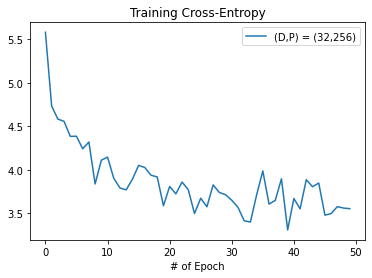

In [131]:
plt.plot(model_history['TrainLoss'])
plt.xlabel('# of Epoch')
plt.title('Training Cross-Entropy')
plt.legend(['(D,P) = (32,256)'])
plt.show()

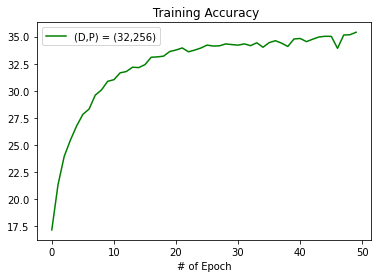

In [148]:
plt.plot(model_history['TrainAcc'],color = 'green')
plt.xlabel('# of Epoch')
plt.title(' Training Accuracy')
plt.legend(['(D,P) = (32,256)'])
plt.show()

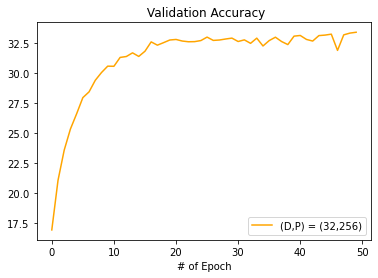

In [149]:
plt.plot(model_history['ValAcc'],color = 'orange')
plt.xlabel('# of Epoch')
plt.title(' Validation Accuracy')
plt.legend(['(D,P) = (32,256)'])
plt.show()

In [527]:
# Note that np.random.seed() is not placed to see different results in differents runnings
test_preds = model.predict(test_data)
test_acc = model.accuracy_score(test_preds,np.argmax(test_label,1))
print(f'Test Accuracy: {test_acc}')

forward = model.forward(test_data)
probs_softmax = forward['A2']

num_sample = test_data.shape[0]
n_predict = 5
random_idx = np.random.randint(num_sample,size = n_predict)

# 5 random sample's probabilities
five_random_num_probs = probs_softmax[random_idx]
random_five_words = data['Corpus'][data['TestX'][random_idx]].astype('U13')


Test Accuracy: 32.00645161290323


In [528]:
def top_k_preds(probs,k,n_predict):
    top_k = np.zeros((n_predict,k))
    for i in range(n_predict):
         top_k[i] = probs.argsort()[i][-k:][::-1]
    return top_k
top_10_preds = top_k_preds(five_random_num_probs,10,5) 
top_10_words = data['Corpus'][top_10_preds.astype('int')].astype('U13')

In [529]:
input_words = [list(random_five_words[i]) for i in range(n_predict)] 
preds_words = [list(top_10_words[i]) for i in range(n_predict)]
print('_____________________________________________________________________________________________\n')
for i in range(n_predict):    
    print('Input word',i+1,'----->',  ', '.join(input_words[i]),'\nTop 10 predicted candicates :', ', '.join(preds_words[i]),            '\n_____________________________________________________________________________________________\n') 

_____________________________________________________________________________________________

Input word 1 -----> only, which, high 
Top 10 predicted candicates : ., out, on, do, the, to, it, work, ?, one 
_____________________________________________________________________________________________

Input word 2 -----> and, an, at 
Top 10 predicted candicates : own, day, home, game, life, last, time, first, ., team 
_____________________________________________________________________________________________

Input word 3 -----> still, political, including 
Top 10 predicted candicates : he, she, it, and, they, ., i, too, but, is 
_____________________________________________________________________________________________

Input word 4 -----> what, still, only 
Top 10 predicted candicates : work, school, ., to, the, home, out, know, do, there 
_____________________________________________________________________________________________

Input word 5 -----> under, only, them 
Top 10 pr

In [530]:
#model_16x128 = Word2Vec(16,128)
#model_16x128.fit(train_data,train_label,test_data,test_label,epochs = 50)

In [531]:
#model_16x128_history = model_16x128.history()

In [532]:
#plt.plot(model_16x128_history['TrainLoss'])
#plt.legend(['(D,P) = (16,128)'])
#plt.xlabel('# of Epoch')
#plt.title('Training Cross-Entropy')
#plt.show()

In [533]:
#plt.plot(model_16x128_history['TrainAcc'],color = 'green')
#plt.legend(['(D,P) = (16,128)'])
#plt.xlabel('# of Epoch')
#plt.title(' Training Accuracy')
#plt.show()

In [534]:
#plt.plot(model_16x128_history['ValAcc'],color = 'orange')
#plt.legend(['(D,P) = (16,128)'])
#plt.xlabel('# of Epoch')
#plt.title('Validation Accuracy')
#plt.show()

In [535]:
#model_8x64 = Word2Vec(8,64)
#model_8x64.fit(train_data,train_label,test_data,test_label,epochs = 50)

In [536]:
#model_8x64_history = model_8x64.history()

In [537]:
#plt.plot(model_8x64_history['TrainLoss'])
#plt.legend(['(D,P) = (8,64)'])
#plt.xlabel('# of Epoch')
#plt.title('Training Cross-Entropy')
#plt.show()

In [538]:
#plt.plot(model_8x64_history['TrainAcc'],color = 'green')
#plt.legend(['(D,P) = (8,64)'])
#plt.xlabel('# of Epoch')
#plt.title(' Training Accuracy')
#plt.show()

In [539]:
#plt.plot(model_8x64_history['ValAcc'],color = 'orange')
#plt.legend(['(D,P) = (8,64)'])
#plt.xlabel('# of Epoch')
#plt.title('Validation Accuracy')
#plt.show()